#  <font color='#57998f'>Computing Equilibria | FP & RL</font>
###  <font color='#37665f'>Dependencies</font> 

In [62]:
import time
import pulp
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

###  <font color='#37665f'>Games</font> 

In [2]:
# Game: matching pennies
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

# Game: rock-paper-scissors
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

# Game: zero-sum with pure nash equilibrium
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

##  <font color='#37665f'>Fictitious Play</font> 
### <font color='#425451'>Define FP Player</font> 

In [3]:
class FPZeroSumPlayer():

    def __init__(self, payoff_matrix, w_init=None):
        
        self.payoff_matrix = payoff_matrix
        
        if w_init == None:
            self.w = np.random.uniform(low=1, high=1.01, size=(len(self.payoff_matrix),))
        else:
            self.w = w_init
            
        self.p = self.w / np.sum(self.w)
        
        self.policy = np.zeros(len(self.payoff_matrix))
        self.policy_delta = None
        
        self.update_policy()
                
        self.belief = None
        self.action = None
        self.reward = None


    def take_action(self, learning=True):
        
        self.belief = np.argmax(self.p)
        
        self.action = np.argmax(self.payoff_matrix[:,self.belief])

        return self.action

    
    def learn(self,opponent_action):
        
        self.w[opponent_action] += 1
        
        self.p = self.w / np.sum(self.w)
        
        self.reward = self.payoff_matrix[self.action][opponent_action]
                
        self.update_policy()
        
        
    def update_policy(self):
        
        current_policy = self.policy
        
        new_policy = np.zeros(len(self.payoff_matrix))
            
        for idx, p in enumerate(self.p):
            new_policy[np.argmax(self.payoff_matrix[:,idx])] += p
            
        self.policy = new_policy
        
        self.policy_delta = max([abs(i-j) for i,j in zip(current_policy, new_policy)])

### <font color='#425451'>Define FP Play Game Function</font> 

In [226]:
def play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres): 
    
    game_history = pd.DataFrame(columns=['round', 'action_1', 'action_2', 'beliefs_1', 'beliefs_2', 
                                         'policy_1', 'policy_2', 'policy_delta_1', 'policy_delta_2',
                                         'reward_1', 'reward_2'])

    game_history = game_history.append({'beliefs_1':player_1.p.round(3), 'beliefs_2':player_2.p.round(3), 
                                        'policy_1':player_1.policy.round(3), 'policy_2':player_2.policy.round(3)},
                                       ignore_index=True)

    start_time = time.time()

    stable_policy_delta_rounds_count = 0 

    for i in range(1, max_iterations+1):

        action_1 = player_1.take_action()
        action_2 = player_2.take_action()

        player_1.learn(opponent_action=action_2)
        player_2.learn(opponent_action=action_1)  

        game_history = game_history.append({'round':i, 'action_1':actions_map[action_1], 'action_2':actions_map[action_2], 
                                            'beliefs_1':player_1.p.round(3), 'beliefs_2':player_2.p.round(3), 
                                            'policy_1':player_1.policy.round(3), 'policy_2':player_2.policy.round(3), 
                                            'policy_delta_1':player_1.policy_delta, 
                                            'policy_delta_2':player_2.policy_delta,
                                            'reward_1':player_1.reward, 'reward_2':player_2.reward}, ignore_index=True)


        if (player_1.policy_delta < policy_delta_thres) & (player_2.policy_delta < policy_delta_thres) :
            stable_policy_delta_rounds_count += 1
        else:
            stable_policy_delta_rounds_count = 0

        if stable_policy_delta_rounds_count >= stable_policy_delta_rounds_thres:

            print('Congrats! A Nash Equilibrium was reached! \U0001F389 \n')
            print('Player 1 policy: ' + str(player_1.policy.round(1)))
            print('Player 2 policy: ' + str(player_2.policy.round(1)))

            time_elapsed = time.time() - start_time 
            print('\nTime elapsed: {:.2f}s'.format(time_elapsed))
            print('Number of rounds elapsed: ' + str(i))

            break

    if stable_policy_delta_rounds_count < stable_policy_delta_rounds_thres:
        print('No Nash Equilibrium was reached based on the below defined criteria. \U0001F622')
        print('Policy delta threshold: ' + str(policy_delta_thres))
        print('Number of rounds with stable policy needed: ' + str(stable_policy_delta_rounds_thres))
        print('Max rounds: ' + str(max_iterations))
    
    plt.style.use('seaborn')
    color_plt = sns.color_palette('Set1')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    for action in actions_map.keys():
        ax1.plot(game_history['round'], game_history['policy_1'].apply(pd.Series)[action], ls ='--', color=color_plt[action], label=actions_map[action])
        ax2.plot(game_history['round'], game_history['policy_2'].apply(pd.Series)[action], ls ='--', color=color_plt[action], label=actions_map[action])

    ax1.set_xlim(-10,game_history['round'].max()+10)
    ax2.set_xlim(-10,game_history['round'].max()+10)

    ax1.set_title('Player 2: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)
    ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\n No Nash Equilibrium', fontsize=13)


    ax1.set_ylabel('Action Probability\n', fontsize=10, color='black')
    ax1.set_xlabel('Game Round', fontsize=10, color='black')
    ax2.set_xlabel('Game Round', fontsize=10, color='black')

    if stable_policy_delta_rounds_count >= stable_policy_delta_rounds_thres:
        ax1.set_title('Player 1: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      + str(game_history.iloc[-1,game_history.columns.get_loc('policy_1')].round(1)), fontsize=13)
        ax2.set_title('Player 2: Policy - Actions\' Probabilities \n\nNash Equilibrium: ' \
                      + str(game_history.iloc[-1,game_history.columns.get_loc('policy_2')].round(1)), fontsize=13)
        ax1.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)
        ax2.axvspan(game_history['round'].max() - stable_policy_delta_rounds_thres, game_history['round'].max()+10, facecolor='#7ff09d', alpha=0.1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.show()
        
    return game_history

### <font color='#425451'>Experiments</font> 

####  <font color='#425451'>Game: Matching Pennies</font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [227]:
max_iterations = 2000

policy_delta_thres = 0.001

stable_policy_delta_rounds_thres = 200

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [228]:
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

actions_map = {0: 'H', 1: 'T'}

<font color='#425451'>Initialize FP Players</font> 

In [229]:
player_1 = FPZeroSumPlayer(payoff_matrix)

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.5 0.5]
Player 2 policy: [0.5 0.5]

Time elapsed: 7.64s
Number of rounds elapsed: 713


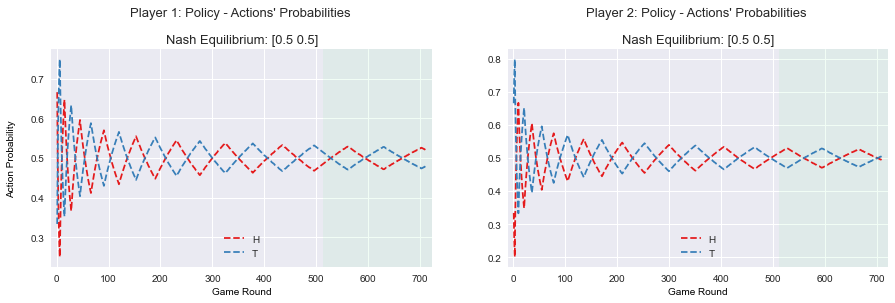

In [230]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [231]:
game_log.head(5)

,round,action_1,action_2,beliefs_1,beliefs_2,policy_1,policy_2,policy_delta_1,policy_delta_2,reward_1,reward_2
0,NaN,NaN,NaN,"[0.5, 0.5]","[0.5, 0.5]","[0.5, 0.5]","[0.5, 0.5]",NaN,NaN,NaN,NaN
1,1,H,H,"[0.666, 0.334]","[0.666, 0.334]","[0.666, 0.334]","[0.334, 0.666]",0.165645,0.166275,1,-1
2,2,H,T,"[0.5, 0.5]","[0.749, 0.251]","[0.5, 0.5]","[0.251, 0.749]",0.165808,0.083318,-1,1
3,3,H,T,"[0.4, 0.6]","[0.799, 0.201]","[0.4, 0.6]","[0.201, 0.799]",0.099704,0.050048,-1,1
4,4,T,T,"[0.334, 0.666]","[0.666, 0.334]","[0.334, 0.666]","[0.334, 0.666]",0.066560,0.133036,1,-1


<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

No Nash Equilibrium was reached based on the below defined criteria. 😢
Policy delta threshold: 0.0001
Number of rounds with stable policy needed: 50
Max rounds: 1000


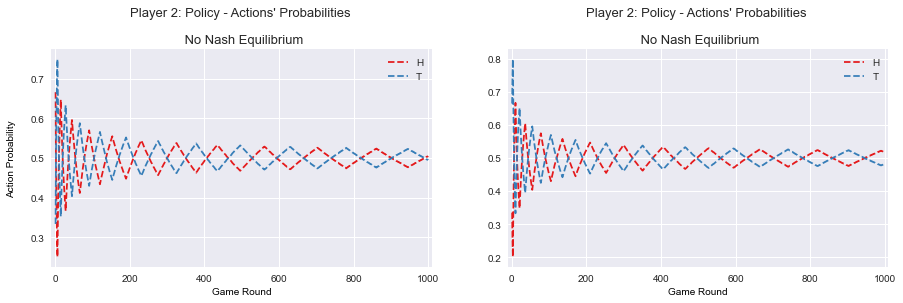

In [232]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations=1000, policy_delta_thres=0.0001, stable_policy_delta_rounds_thres=50)

####  <font color='#425451'>Game: Rock-Paper-Scissors </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [233]:
max_iterations = 2000
policy_delta_thres = 0.002
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [234]:
payoff_matrix = np.array([[ 0,-1, 1],
                          [ 1, 0,-1],
                          [-1, 1, 0]])

actions_map = {0: 'Rock', 1: 'Paper', 2:'Scissors'}

<font color='#425451'>Initialize FP Players</font> 

In [235]:
player_1 = FPZeroSumPlayer(payoff_matrix, w_init=[1,1,1])

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix, w_init=[1,1,1])

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.3 0.3 0.3]
Player 2 policy: [0.3 0.3 0.3]

Time elapsed: 3.58s
Number of rounds elapsed: 360


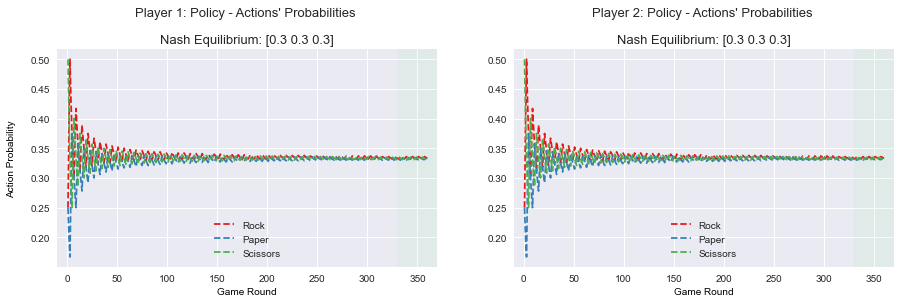

In [236]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

In [237]:
game_log[['round','action_1','action_2','beliefs_1','beliefs_2','policy_1','policy_2']].head(8)

,round,action_1,action_2,beliefs_1,beliefs_2,policy_1,policy_2
0,NaN,NaN,NaN,"[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]"
1,1,Paper,Paper,"[0.25, 0.5, 0.25]","[0.25, 0.5, 0.25]","[0.25, 0.25, 0.5]","[0.25, 0.25, 0.5]"
2,2,Scissors,Scissors,"[0.2, 0.4, 0.4]","[0.2, 0.4, 0.4]","[0.4, 0.2, 0.4]","[0.4, 0.2, 0.4]"
3,3,Scissors,Scissors,"[0.167, 0.333, 0.5]","[0.167, 0.333, 0.5]","[0.5, 0.167, 0.333]","[0.5, 0.167, 0.333]"
4,4,Rock,Rock,"[0.286, 0.286, 0.429]","[0.286, 0.286, 0.429]","[0.429, 0.286, 0.286]","[0.429, 0.286, 0.286]"
5,5,Rock,Rock,"[0.375, 0.25, 0.375]","[0.375, 0.25, 0.375]","[0.375, 0.375, 0.25]","[0.375, 0.375, 0.25]"
6,6,Paper,Paper,"[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]","[0.333, 0.333, 0.333]"
7,7,Paper,Paper,"[0.3, 0.4, 0.3]","[0.3, 0.4, 0.3]","[0.3, 0.3, 0.4]","[0.3, 0.3, 0.4]"


<font color='#425451'>Try with other initial beliefs</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.6 0.3 0.1]
Player 2 policy: [0.2 0.4 0.4]

Time elapsed: 7.39s
Number of rounds elapsed: 708


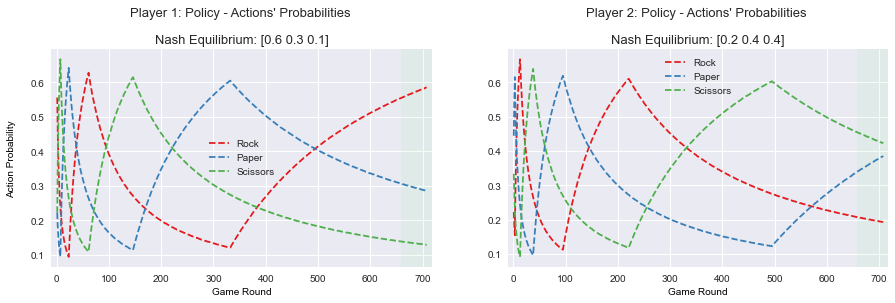

In [238]:
player_1 = FPZeroSumPlayer(payoff_matrix, w_init=[1,1,1.5])
player_2 = FPZeroSumPlayer(column_payoff_matrix, w_init=[1,1.5,1])

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.001, stable_policy_delta_rounds_thres=50)

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.3 0.3 0.3]
Player 2 policy: [0.3 0.3 0.3]

Time elapsed: 8.07s
Number of rounds elapsed: 712


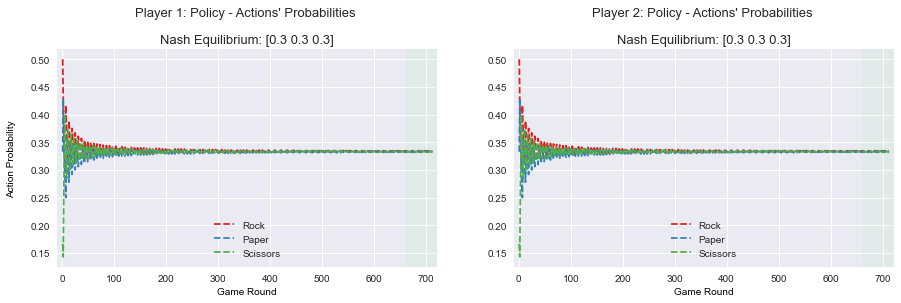

In [239]:
player_1 = FPZeroSumPlayer(payoff_matrix, w_init=[1,1,3])
player_2 = FPZeroSumPlayer(column_payoff_matrix, w_init=[1,1,3])

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.001, stable_policy_delta_rounds_thres=50)

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [0.2 0.5 0.3]
Player 2 policy: [0.5 0.2 0.3]

Time elapsed: 20.81s
Number of rounds elapsed: 1773


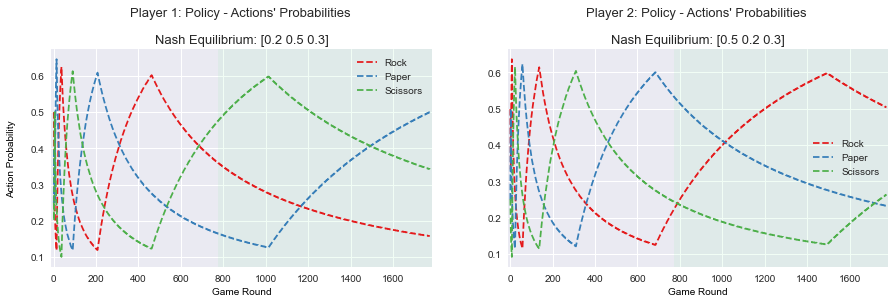

In [240]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.001, stable_policy_delta_rounds_thres=1000)

####  <font color='#425451'>Game: Pure Strategy Nash Equilibrium Game </font> 

<font color='#425451'>Configure Equilibrium Criteria</font> 

In [241]:
max_iterations = 2000
policy_delta_thres = 0.002
stable_policy_delta_rounds_thres = 30

<font color='#425451'>Game's Pay-off Matrix & action mapping</font> 

In [242]:
payoff_matrix = np.array([[ 2, 0, 1],
                          [-4,-3, 2],
                          [ 1,-2,-2]])

actions_map = {0: 'Action 1', 1: 'Action 2', 2:'Action 3'}

<font color='#425451'>Initialize FP Players</font> 

In [243]:
player_1 = FPZeroSumPlayer(payoff_matrix)

column_payoff_matrix = (-1) * payoff_matrix.T

player_2 = FPZeroSumPlayer(column_payoff_matrix)

<font color='#425451'>Play Game</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [1. 0. 0.]
Player 2 policy: [0. 1. 0.]

Time elapsed: 0.52s
Number of rounds elapsed: 49


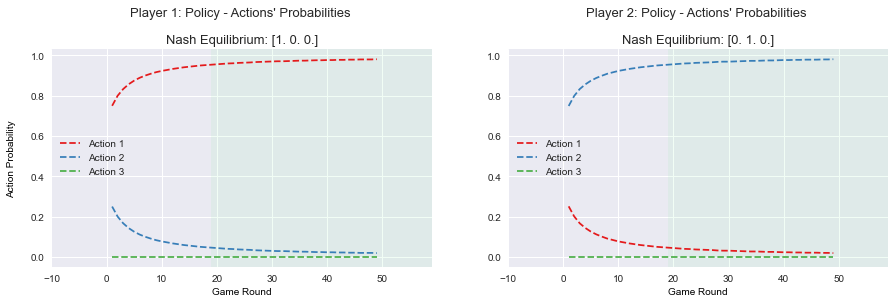

In [244]:
game_log = play_fp_game(player_1, player_2, actions_map, max_iterations, policy_delta_thres, stable_policy_delta_rounds_thres)

<font color='#425451'>Try with other Nash Equilibrium criteria</font> 

Congrats! A Nash Equilibrium was reached! 🎉 

Player 1 policy: [1. 0. 0.]
Player 2 policy: [0. 1. 0.]

Time elapsed: 10.83s
Number of rounds elapsed: 1031


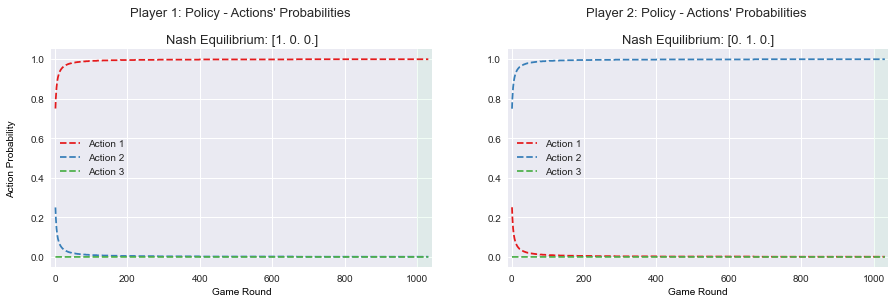

In [245]:
player_1 = FPZeroSumPlayer(payoff_matrix)
player_2 = FPZeroSumPlayer(column_payoff_matrix)

game_log = play_fp_game(player_1, player_2, actions_map, 
                        max_iterations, policy_delta_thres=0.000001, stable_policy_delta_rounds_thres=30)

## <font color='#37665f'>Reinforcement Learning</font> 
####  <font color='#425451'>Reward helper function</font> 

In [203]:
def get_reward(payoff_matrix, action_1, action_2):
    
    reward_1 = payoff_matrix[action_1, action_2]
    reward_2 = (-1) * payoff_matrix[action_1, action_2]

    return reward_1, reward_2

###  <font color='#425451'>Define Player</font> 

In [23]:
class RLZeroSumPlayer():

    def __init__(self, alpha, gamma, explor, actions, state_init='s'):

        self.alpha = alpha
        self.gamma = gamma
        self.explor = explor
        self.actions = actions
        self.state = state_init
        
        self.states = []
        
        self.Q = {}
        self.V = {}
        self.Pi = {}
        self.action = None

        self.init_state(state_init)

        self.game_history = []
        
    def init_state(self, state):
        
        self.states.append(state)
        
        self.V[state] = 1

        for action_1 in self.actions: 
            for action_2 in self.actions:
                self.Q[(state, action_1, action_2)] = 1

        for action in self.actions:
            self.Pi[(state, action)] = 1/len(self.actions) 


    def take_action(self, learning=True):

        if learning & (np.random.rand() < self.explor): 
            self.action = np.random.choice(self.actions)
        else:
            self.action = np.random.choice([i[1] for i in self.Pi.keys() if i[0]==self.state], 
                                           p=[self.Pi[i] for i in self.Pi.keys() if i[0]==self.state])   

        return self.action

    
    def learn(self, reward, opponent_action, state='s'):
        
        if state not in self.states: 
            self.init_state(state)
        
        self.update_Q(reward, opponent_action, state)
        self.update_Pi()
        self.update_V(state)
        
        self.game_history.append((self.state, self.action, opponent_action))
        
        self.state = state

    def update_Q(self, reward, opponent_action, new_state):
        
        kappa = len([i for i in player_1.game_history if i == (self.state, self.action, opponent_action)])
        alpha = 1/kappa if kappa>0 else self.alpha
        
        current_Q = self.Q[(self.state, self.action, opponent_action)]
        updated_Q = (1 - alpha)*current_Q + alpha*(reward + self.gamma*self.V[new_state])
        
        self.Q[(self.state, self.action, opponent_action)] = updated_Q

        
    def update_Pi(self):     
        
        pi = pulp.LpVariable.dicts('pi', self.actions, 0, 1)
        maxmin = pulp.LpVariable('maxmin')
        lp_prob = pulp.LpProblem('MaxMinQ', pulp.LpMaximize)
        lp_prob += (maxmin, 'Objective')
        lp_prob += (sum([pi[i] for i in self.actions]) == 1)

        for opponent_action in self.actions:
            label = '{}'.format(opponent_action)
            l = [pi[idx] * self.Q[(self.state, action, opponent_action)] for idx, action in enumerate(self.actions)]
            values = pulp.lpSum(l)
            condition = maxmin <= values
            lp_prob += condition

        lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

        for i in self.actions:
            self.Pi[(self.state,i)] = pi[i].value()
        
    def update_V(self, state):
        
        expected_values = []

        for opponent_action in self.actions:
            expected_value = sum([self.Pi[(state, action)]*self.Q[(state, action, opponent_action)] for action in self.actions])
            expected_values.append(expected_value)

        self.V[self.state] = min(expected_values)


####  <font color='#425451'>Initialize Players</font> 

In [24]:
alpha = 1
gamma = 0.9
explor = 0.2
initial_state = 's'
actions = list(range(len(payoff_matrix)))

player_1 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)
player_2 = RLZeroSumPlayer(alpha, gamma, explor, actions, initial_state)

####  <font color='#425451'>Play Game</font> 

In [25]:
for i in range(30):
    action_1 = player_1.take_action()
    action_2 = player_2.take_action()
 
    reward_1, reward_2 = get_reward(payoff_matrix, action_1, action_2)

    player_1.learn(reward=reward_1, opponent_action=action_2, state='s')
    player_2.learn(reward=reward_2, opponent_action=action_1, state='s')

In [26]:
player_1.Pi

{('s', 0): 1.0, ('s', 1): 0.0, ('s', 2): 0.0}

In [27]:
player_2.Pi

{('s', 0): 0.0, ('s', 1): 1.0, ('s', 2): 0.0}

In [28]:
player_1.Q

{('s', 0, 0): 2.6911357572439174,
 ('s', 0, 1): 0.7065369171448707,
 ('s', 0, 2): 1.7381509109575957,
 ('s', 1, 0): -3.18785713996,
 ('s', 1, 1): -2.2363056296380335,
 ('s', 1, 2): 2.9,
 ('s', 2, 0): 1.9,
 ('s', 2, 1): -1.1,
 ('s', 2, 2): 1}

In [29]:
player_2.Q

{('s', 0, 0): -1.3377382092184442,
 ('s', 0, 1): 4.8850257397,
 ('s', 0, 2): -0.09999999999999998,
 ('s', 1, 0): 0.3545259668744063,
 ('s', 1, 1): 3.59048286035917,
 ('s', 1, 2): 2.8209505736,
 ('s', 2, 0): -0.11599363426894271,
 ('s', 2, 1): -1.1,
 ('s', 2, 2): 1}

In [806]:
payoff_matrix

[[(2, -2), (0, 0), (1, -1)],
 [(4, -4), (-1, 1), (2, -2)],
 [(1, -1), (3, -3), (-2, 2)]]

####  <font color='#425451'>Drafts</font> 

In [378]:
pi = pulp.LpVariable.dicts('pi', player_1.actions, 0, 1)
maxmin = pulp.LpVariable('maxmin')
lp_prob = pulp.LpProblem('MaxMinQ', pulp.LpMaximize)
lp_prob += (maxmin, 'Objective')
lp_prob += (sum([pi[i] for i in player_1.actions]) == 1)

for opponent_action in player_1.actions:
    label = '{}'.format(opponent_action)
    l = [pi[idx] * player_1.Q[(player_1.state, action, opponent_action)] for idx, action in enumerate(player_1.actions)]
    values = pulp.lpSum(l)
    condition = maxmin <= values
    lp_prob += condition
    
lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

for i in player_1.actions:
    player_1.Pi[(player_1.state,i)] = pi[i].value()

[0.0, 0.0, 1.0]

In [380]:
lp_prob

MaxMinQ:
MAXIMIZE
1*maxmin + 0
SUBJECT TO
_C1: pi_0 + pi_1 + pi_2 = 1

_C2: maxmin - pi_0 - pi_1 - pi_2 <= 0

_C3: maxmin - pi_0 - pi_1 - 1.9 pi_2 <= 0

_C4: maxmin - pi_0 - pi_1 - pi_2 <= 0

VARIABLES
maxmin free Continuous
pi_0 <= 1 Continuous
pi_1 <= 1 Continuous
pi_2 <= 1 Continuous

Text(0.5, 0, '\n Training Dataset Size')

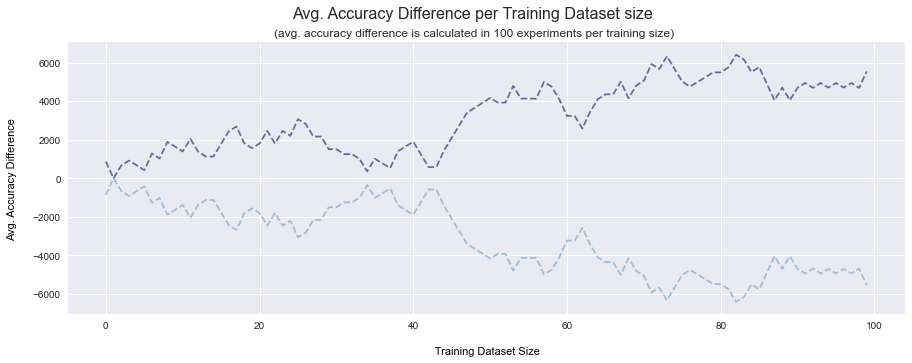

In [26]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn')
color_plt = sns.color_palette("ch:s=.25,rot=-.25")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)
ax = plt.gca()

plot = plt.plot([i for i in range(len(rewards_p1_cum))], rewards_p1_cum, ls ='--', color=color_plt[1], label='')
plot = plt.plot([i for i in range(len(rewards_p2_cum))], rewards_p2_cum, ls ='--', color=color_plt[3], label='')

plt.suptitle('Avg. Accuracy Difference per Training Dataset size', fontsize=16)
plt.title('(avg. accuracy difference is calculated in 100 experiments per training size)       ')
plt.yticks(fontsize=10)
plt.ylabel('Avg. Accuracy Difference\n', fontsize=11, color='black')
plt.xlabel('\n Training Dataset Size', fontsize=11, color='black')

In [305]:
# c=0
# rewards_p2_cum = np.array([])
# for i in rewards_p2:
#     print(c)
#     c += i
#     rewards_p2_cum = np.append(rewards_p2_cum, c)

In [94]:
rewards_p1_cum = np.array([])


In [741]:
# Game: matching pennies
payoff_matrix = np.array([[ 1,-1],
                          [-1, 1]])

# Game: rock-paper-scissors
# payoff_matrix = np.array([[ 0,-1, 1],
#                           [ 1, 0,-1],
#                           [-1, 1, 0]])

# Game: zero-sum with pure nash equilibrium
# payoff_matrix = np.array([[ 2, 0, 1],
#                           [-4,-3, 2],
#                           [ 1,-2,-2]])

In [409]:
num_iter = 5

strategy = np.zeros([num_iter,3])
empirical = np.zeros([num_iter,3])

payoffs = np.zeros([2,2])


In [398]:
payoffs

array([[0., 0.],
       [0., 0.]])

In [743]:
payoff_matrix[3,0]

IndexError: index 3 is out of bounds for axis 0 with size 2

In [404]:
for i in range(1,5):
    
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = empirical[i-1,1]*payoff_matrix[0,0] + (1-empirical[i-1,1])*payoff_matrix[0,1]
    payoffs[1,0] = empirical[i-1,1]*payoff_matrix[1,0] + (1-empirical[i-1,1])*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = empirical[i-1,0]*payoff_matrix[2,0] + (1-empirical[i-1,0])*payoff_matrix[3,0]
    payoffs[1,1] = empirical[i-1,0]*payoff_matrix[2,1] + (1-empirical[i-1,0])*payoff_matrix[3,1]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [410]:
empirical

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [405]:
payoffs[0,0] = empirical[i-1,1]*payoff_matrix[0,0] + (1-empirical[i-1,1])*payoff_matrix[0,1]

In [ ]:
for i in range(1,num_iter):
    
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = empirical[i-1,1]*payoff_matrix[0,0] + (1-empirical[i-1,1])*payoff_matrix[0,1]
    payoffs[1,0] = empirical[i-1,1]*payoff_matrix[1,0] + (1-empirical[i-1,1])*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = empirical[i-1,0]*payoff_matrix[2,0] + (1-empirical[i-1,0])*payoff_matrix[3,0]
    payoffs[1,1] = empirical[i-1,0]*payoff_matrix[2,1] + (1-empirical[i-1,0])*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 0
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 1
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 0
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 1
    else:
        strategy[i,1] = strategy[i-1,1]


    # update the empirical distribution
    empirical[i,0] = ((i-1)*empirical[i-1,0] + strategy[i,0])/i
    empirical[i,1] = ((i-1)*empirical[i-1,1] + strategy[i,1])/i
        
    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter
    empirical[i,2] = i/num_iter


In [ ]:
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = empirical[i-1,1]*payoff_matrix[0,0] + (1-empirical[i-1,1])*payoff_matrix[0,1]
    payoffs[1,0] = empirical[i-1,1]*payoff_matrix[1,0] + (1-empirical[i-1,1])*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = empirical[i-1,0]*payoff_matrix[2,0] + (1-empirical[i-1,0])*payoff_matrix[3,0]
    payoffs[1,1] = empirical[i-1,0]*payoff_matrix[2,1] + (1-empirical[i-1,0])*payoff_matrix[3,1]

In [ ]:
#! /usr/bin/env python
import numpy

# number of iterations
num_iter = 100

# payoff matrix for the two players in the 2x2 game
# first two rows are player 1's payoff matrix, and the last two player 2's
payoff_matrix = numpy.zeros([4,2])

# 'strategy' stores the strategy played in each time period
strategy = numpy.zeros([num_iter,3])

# 'empirical' stores the empirical distribution at each time period
empirical = numpy.zeros([num_iter,3])

# 'payoffs' stores the payoff for each player, assuming the other
# player plays according to the empirical distribution
payoffs = numpy.zeros([2,2])

# matching pennies
payoff_matrix[:2,:] = [ [1, -1], [-1, 1]]
payoff_matrix[2:,:] = [ [-1, 1], [1, -1]]

# coordination game
#payoff_matrix[:2,:] = [ [1, 0], [0, 2]]
#payoff_matrix[2:,:] = [ [2, 0], [0, 1]]
#strategy[0,1] = 1
#empirical[0,1] = 1

# prisoner's dilemma
# payoff_matrix[:2,:] = [ [-1, -10], [0, -5]]
# payoff_matrix[2:,:] = [ [-1, 0], [-10, -5]]
# strategy[0,0] = 1
# strategy[0,1] = 1
# empirical[0,0] = 1
# empirical[0,1] = 1


for i in range(1,num_iter):
    
    # calculate payoff of player 1 assuming the other player plays according to empirical dist.
    payoffs[0,0] = empirical[i-1,1]*payoff_matrix[0,0] + (1-empirical[i-1,1])*payoff_matrix[0,1]
    payoffs[1,0] = empirical[i-1,1]*payoff_matrix[1,0] + (1-empirical[i-1,1])*payoff_matrix[1,1]

    # calculate payoff of player 2 assuming the other player plays according to empirical dist.
    payoffs[0,1] = empirical[i-1,0]*payoff_matrix[2,0] + (1-empirical[i-1,0])*payoff_matrix[3,0]
    payoffs[1,1] = empirical[i-1,0]*payoff_matrix[2,1] + (1-empirical[i-1,0])*payoff_matrix[3,1]


    # player 1's best response
    if payoffs[0,0] < payoffs[1,0]:
        strategy[i,0] = 0
    elif payoffs[0,0] > payoffs[1,0]:
        strategy[i,0] = 1
    else:
        strategy[i,0] = strategy[i-1,0]


    # player 2's best response
    if  payoffs[0,1] < payoffs[1,1]:
        strategy[i,1] = 0
    elif payoffs[0,1] > payoffs[1,1]:
        strategy[i,1] = 1
    else:
        strategy[i,1] = strategy[i-1,1]


    # update the empirical distribution
    empirical[i,0] = ((i-1)*empirical[i-1,0] + strategy[i,0])/i
    empirical[i,1] = ((i-1)*empirical[i-1,1] + strategy[i,1])/i
        
    # store the (normalized) number of iterations
    strategy[i,2] = i/num_iter
    empirical[i,2] = i/num_iter
